In [1]:
import pickle 
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
import copy
from src.src_utils import encode_exclude_nan, other_process, impute_per_mode, normalize_per_col

In [60]:
import pkg_resources
from scipy.stats import ranksums, ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from scipy import stats
def FDR_categorical_continous_vars(df_, y, cont_vars, cat_vars):
    """
    df_: the feature dataframe
    y: label vector (dataframe prefered)
    cont_vars: list of continous variables
    cat_vars: list of categorical variables

    - return: 
      fdr_df: dataframe stored fdr by feature names & also missingness stats
    """
    cont_pvals = []
    new_cont_vars = []
    for cont_var in cont_vars:
        var = df_[cont_var]
        if np.array(var.dropna()).shape[0] != 0:

            pos_subject_vals = var.loc[list(y==1)].dropna()
            neg_subject_vals = var.loc[list(y==0)].dropna()
            
            result = ranksums(pos_subject_vals, neg_subject_vals)
            
            if isinstance(result.pvalue, np.float64):
                pval = result.pvalue
            else:
                pval = result.pvalue[0]
                
            new_cont_vars.append(cont_var)
            cont_pvals.append(pval)
    
    num_cont = len(cont_vars)
    cont_vars = new_cont_vars   
  
    cat_pvals = []
    for cat_var in cat_vars:

        var = df_[cat_var]
        if np.array(var.dropna()).shape[0] == 0:
            cat_vars.remove(cat_var)
        else:
            pos_subject_vals = var.loc[list(y==1)].dropna()
            neg_subject_vals = var.loc[list(y==0)].dropna()
            cont_mat = pd.crosstab(index=var, columns=y).values
            
            pval = stats.chi2_contingency(cont_mat)[1]
            cat_pvals.append(pval)
    #print(type(cont_pvals))
    #print(type(cat_pvals))
    #return cont_pvals, cat_pvals
    
    fdr = fdrcorrection(cont_pvals+cat_pvals)[1]
    all_vars = cont_vars+cat_vars
    missing_list = [df_[k].isnull().sum() for k in all_vars]
    missing_CI_list = [df_.loc[y==1, k].isnull().sum() for k in all_vars]
    missing_nonCI_list = [df_.loc[y==0, k].isnull().sum() for k in all_vars]

    fdr_df = pd.DataFrame({'feature': all_vars, 'FDR': fdr,
                        'missing (whole cohort)': missing_list,
                        'missing (positive cases)': missing_CI_list,
                        'missing (negative cases)': missing_nonCI_list})

    fdr_df.sort_values(by='FDR', inplace=True)

    cont_pval_df = pd.DataFrame({'feature': cont_vars, 'pval': cont_pvals})
    cont_pval_df.sort_values(by='pval', inplace=True)
    
    return fdr_df, cont_pval_df, cat_pvals

In [58]:
data_file_path = 'data/processed/tadpole_data_train_test.pickle'
with open(data_file_path, 'rb') as file:
    fdr_data = pickle.load(file)

label_file_path = 'data/processed/tadpole_labels_train_test.pickle'
with open(label_file_path, 'rb') as file:
    fdr_labels = pickle.load(file)

#process_tadpole_dict = copy.deepcopy(tadpole_data)

In [61]:
div = 'train'
univar_concat = pd.DataFrame()
for mode in fdr_data['mci_bl'][div]:
    univar_concat = pd.concat([univar_concat, fdr_data['mci_bl'][div][mode]], axis=1)

y = np.array(fdr_labels['mci_bl'][div].map({'MCI': 0.0, 'DEM': 1.0})).astype(int)

cat_vars = ['DX_bl', 'PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY']
cont_vars = list(set(univar_concat.columns) - set(cat_vars))
fdr_df,_,_ = FDR_categorical_continous_vars(univar_concat, y, cont_vars, cat_vars)

mode_for_feature = []
for feat in fdr_df['feature']:
    for mode in fdr_data['mci_bl'][div]:
        for eq_feat in fdr_data['mci_bl'][div][mode]:
            if feat == eq_feat:
                mode_for_feature += [mode]

fdr_df['modality'] = mode_for_feature
fdr_df.to_csv('output/tables/fdr_differential_analysis.csv')

In [63]:
fdr_df

,feature,FDR,missing (whole cohort),missing (positive cases),missing (negative cases),modality
286,ADAS13,9.796163e-28,4,3,1,main_cognitive_tests
293,FAQ,5.881322e-23,2,1,1,main_cognitive_tests
152,ADAS11,1.032503e-22,1,0,1,main_cognitive_tests
41,Volume (WM Parcellation) of LeftHippocampus,1.180442e-20,7,0,7,MRI ROI: Volume (WM Parcellation)
256,Volume (WM Parcellation) of RightHippocampus,8.533589e-20,7,0,7,MRI ROI: Volume (WM Parcellation)
...,...,...,...,...,...,...
140,Cortical Thickness Standard Deviation of LeftF...,9.784489e-01,7,0,7,MRI ROI: Cortical Thickness Standard Deviation
24,Surface Area of LeftParsOpercularis,9.784489e-01,7,0,7,MRI ROI: Surface Area
21,Cortical Thickness Standard Deviation of LeftI...,9.818665e-01,7,0,7,MRI ROI: Cortical Thickness Standard Deviation
338,PTETHCAT,9.999538e-01,0,0,0,other


### EI

In [1]:
import sys
sys.path.append('src/ei_python/')
from src.ei_python.ei import EnsembleIntegration,  MeanAggregation, MedianAggregation
from src.ei_python.utils import f_minority_score
from src.src_utils import EI_model_train_and_save, fmeasure_score
from src.ei_python.interpretation import *
import pickle 
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import copy

from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, precision_recall_curve, \
    matthews_corrcoef, precision_recall_fscore_support, make_scorer
import sklearn


In [33]:
# Predictors

past_base_predictors = {
        'NB': GaussianNB(),
        'LR': make_pipeline(StandardScaler(), LogisticRegression()),
        "SVM": make_pipeline(Normalizer(), SVC(kernel='poly', degree=1, probability=True)),
        "Perceptron": Perceptron(),
        'AdaBoost': AdaBoostClassifier(n_estimators=10),
        "DT": DecisionTreeClassifier(),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=10),
        "RF": RandomForestClassifier(n_estimators=100),
        "XGB": XGBClassifier(n_estimators=100), 
        'KNN': KNeighborsClassifier(n_neighbors=1),
    }

past_meta_models = {
                "RF": RandomForestClassifier(),
                "SVM": SVC(kernel='linear', probability=True, max_iter=1e7),
                "NB": GaussianNB(),
                "LR": LogisticRegression(),
                "ADA": AdaBoostClassifier(),
                "DT": DecisionTreeClassifier(),
                "GB": GradientBoostingClassifier(),
                "KNN": KNeighborsClassifier(),
                "XGB": XGBClassifier()
}

base_predictors = {
        'NB': GaussianNB(),
        'LR': LogisticRegression(),
        "SVM": SVC(probability=True),
        "MLP": MLPClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        "DT": DecisionTreeClassifier(),
        'GradientBoosting': GradientBoostingClassifier(),
        "RF": RandomForestClassifier(),
        "XGB": XGBClassifier(n_estimators=100), 
        'KNN': KNeighborsClassifier(),
    }

base_predictors_test = {
        'NB': GaussianNB(),
        'LR': LogisticRegression(),
        "SVM": SVC(probability=True),
        "MLP": MLPClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        "DT": DecisionTreeClassifier(),
        'GradientBoosting': GradientBoostingClassifier(),
        "RF": RandomForestClassifier(),
        "XGB": XGBClassifier(), 
        'KNN': KNeighborsClassifier(),
    }

altered_base_predictors = {
        'NB': GaussianNB(),
        'LR': LogisticRegression(solver = 'liblinear', class_weight='balanced'),
        "SVM": SVC(kernel = 'linear', probability=True),
        "MLP": MLPClassifier(hidden_layer_sizes=(100, 50)),
        'AdaBoost': AdaBoostClassifier(n_estimators=100),
        "DT": DecisionTreeClassifier(min_samples_leaf=10, min_samples_split=20),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=200),
        "RF": RandomForestClassifier(n_estimators=200),
        "XGB": XGBClassifier(), 
        'KNN': KNeighborsClassifier(),
    }

meta_models = {
        'NB': GaussianNB(),
        'LR': LogisticRegression(),
        "SVM": SVC(probability=True),
        "MLP": MLPClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        "DT": DecisionTreeClassifier(),
        'GradientBoosting': GradientBoostingClassifier(),
        "RF": RandomForestClassifier(),
        "XGB": XGBClassifier(), 
        'KNN': KNeighborsClassifier(),
    }

reg = 0.5
reg_meta_models = {
        'NB': GaussianNB(),
        'LR': LogisticRegression(C = reg),
        "SVM": SVC(kernel = 'linear', probability=True, C = reg),
        "MLP": MLPClassifier(alpha = 0.001),
        'AdaBoost': AdaBoostClassifier(),
        "DT": DecisionTreeClassifier(),
        'GradientBoosting': GradientBoostingClassifier(),
        "RF": RandomForestClassifier(),
        "XGB": XGBClassifier(reg_lambda=2), 
        'KNN': KNeighborsClassifier(),
    }

In [4]:
data_file_path = 'data/processed/tadpole_data_imptn_norm.pickle'
with open(data_file_path, 'rb') as file:
    tadpole_data = pickle.load(file)

label_file_path = 'data/processed/tadpole_labels_imptn_norm.pickle'
with open(label_file_path, 'rb') as file:
    tadpole_labels = pickle.load(file)

In [64]:
tadpole_data['mci_bl']['train'].keys()

dict_keys(['main_cognitive_tests', 'mri_vols', 'csf_bio', 'other', 'MRI ROI: Volume (WM Parcellation)', 'MRI ROI: Volume (Cortical Parcellation)', 'MRI ROI: Surface Area', 'MRI ROI: Cortical Thickness Average', 'MRI ROI: Cortical Thickness Standard Deviation'])

In [35]:
# EI
problem = 'mci_bl'
data_split = 'train'
sampling_strategy = 'undersampling'
save_modifier = 'undersample_test'
#for sampling_strategy in ['undersampling']:
#save_modifier = f'more_samples'
x = tadpole_data[problem][data_split]
y = np.array(tadpole_labels[problem][data_split].map({'MCI': 0.0, 'DEM': 1.0})).astype(int)

EI_model_train_and_save(f'{problem}_{save_modifier}',
                         mode_dict = x, base_predictors = base_predictors,
                         meta_models = meta_models,
                         y = y.astype(int), train = True,  
                         model_building=True, sampling_strategy = sampling_strategy,
                         n_samples=1)
#for mode in x:
    #EI_model_train_and_save(f'{problem}_{mode}_{save_modifier}',base_predictors = base_predictors,
                        #meta_models = meta_models,
                        #mode_dict = {mode: x[mode]}, y=y, train = True,
                        #model_building=True, sampling_strategy = sampling_strategy,
                        #n_samples=1)



###############################################################################################################
######################################## main_cognitive_tests modality ########################################
############################################################################################################### 


Training base predictors and generating data for analysis...
Generating meta training data via nested cross validation...
Training base predictors on outer training sets...

Base predictor training is complete: see "base_summary" attribute for a summary of base predictor performance. Meta training data can be found in "meta_training_data" and "meta_test_data" attributes. Run "train_meta" method for analysis of ensemble algorithms.

Training base predictors and generating data for final ensemble...
Generating meta training data via nested cross validation...
Training base predictors on outer training sets...

Model building: meta training data for the 

In [49]:
tadpole_data['mci_bl']['train']['main_cognitive_tests']

array([[0.22222222, 0.37495313, 0.50438014, ..., 0.46666667, 0.507692  ,
        0.14285714],
       [0.55555556, 0.89988751, 0.95566764, ..., 0.33333333, 1.        ,
        0.42857143],
       [0.        , 0.22497188, 0.23891691, ..., 1.        , 1.        ,
        0.0952381 ],
       ...,
       [0.22222222, 0.2999625 , 0.4512875 , ..., 0.73333333, 0.92      ,
        0.04761905],
       [0.22222222, 0.48743907, 0.50438014, ..., 0.33333333, 0.5428568 ,
        0.04761905],
       [0.        , 0.11248594, 0.13273162, ..., 0.33333333, 0.44      ,
        0.04761905]])

In [45]:
problem = 'mci_bl'
data_split = 'train'
concatenated = {}
pd.DataFrame()
for div in ['train', 'test']:
    concatenated[div] = pd.DataFrame()
    for mode in tadpole_data[problem][data_split]:
        temp = pd.DataFrame(tadpole_data[problem][div][mode])
        concatenated[div] = pd.concat([concatenated[div], temp], axis=1)

div='ext_test'
concatenated[div] = pd.DataFrame()
for mode in tadpole_data['cn_bl_to_mci']['full']:
        temp = pd.DataFrame(tadpole_data['cn_bl_to_mci']['full'][mode])
        concatenated[div] = pd.concat([concatenated[div], temp], axis=1)

In [34]:
# XGB
problem = 'mci_bl'
data_split = 'train'
est = 100
for sampling_strategy in ['undersampling']:
    x = np.array(concatenated[data_split])
    y = np.array(tadpole_labels[problem][data_split].map({'MCI': 0.0, 'DEM': 1.0}))
    EI_model_train_and_save(f'XGB_{problem}_{data_split}_{est}_est_undersampling', single_mode=True, meta_training=False,
                            base_predictors={"XGB": XGBClassifier(n_estimators=est)},
                            mode_dict = x, 
                            y = y.astype(int), train = True, random_state=41, 
                            model_building=True, sampling_strategy=sampling_strategy,
                            n_samples=1)



##################################################################################################
######################################## unimode modality ########################################
################################################################################################## 


Training base predictors and generating data for analysis...
Generating meta training data via nested cross validation...


Training base predictors on outer training sets...

Base predictor training is complete: see "base_summary" attribute for a summary of base predictor performance. Meta training data can be found in "meta_training_data" and "meta_test_data" attributes. Run "train_meta" method for analysis of ensemble algorithms.

Training base predictors and generating data for final ensemble...
Generating meta training data via nested cross validation...
Training base predictors on outer training sets...

Model building: meta training data for the final model has been generated and can be found in the "meta_training_data_final" attribute. Final base predidctors have been saved in the "final_models" attribute.

Saved to EI.XGB_mci_bl_train_more_samples



In [31]:
from sklearn.metrics import precision_recall_curve, auc
model = EnsembleIntegration.load(f'output/models/EI.mci_bl_xgb_100_est_undersampling')

def AUPRC_EI(model):
    auprc_dict = {}
    y_true = model.meta_predictions['labels']
    for predictor in model.meta_predictions:
        if predictor != 'labels':
            y_pred = model.meta_predictions[predictor]
            precision, recall, _ = precision_recall_curve(y_true, y_pred)
            auprc = auc(recall, precision)
            auprc_dict[predictor] = auprc
    auprc_df = pd.DataFrame(auprc_dict, index=['AUPRC']).T
    return auprc_df

In [76]:
model1 = EnsembleIntegration.load(f'output/models/EI.mci_bl_undersample_test')

model1.base_summary['metrics']['other']

ModuleNotFoundError: No module named 'eipy'

In [73]:
model1.meta_test_data[0]

modality       main_cognitive_tests                                          \
base predictor                   NB        LR       SVM       MLP  AdaBoost   
sample                            0         0         0         0         0   
0                          0.033270  0.227822  0.200277  0.221817  0.479326   
1                          0.923105  0.581947  0.676707  0.596806  0.492919   
2                          0.782164  0.571717  0.606191  0.571678  0.482184   
3                          0.987968  0.727718  0.819492  0.769625  0.509946   
4                          0.985474  0.755275  0.755029  0.773913  0.505694   
..                              ...       ...       ...       ...       ...   
130                        0.840802  0.631700  0.686924  0.664240  0.504175   
131                        0.479100  0.490791  0.556980  0.510046  0.511467   
132                        0.000847  0.194883  0.139077  0.117368  0.479362   
133                        0.000246  0.150195  0.143572  0.105677  0.379352   
134                        0.978027  0.674112  0.664781  0.674396  0.509212   

modality                                                   ...  \
base predictor   DT GradientBoosting    RF       XGB  KNN  ...   
sample            0                0     0         0    0  ...   
0               0.0         0.058042  0.29  0.015681  0.2  ...   
1               0.0         0.226417  0.44  0.050035  0.4  ...   
2               1.0         0.200727  0.56  0.136304  0.4  ...   
3               1.0         0.875106  0.88  0.985643  0.8  ...   
4               1.0         0.843998  0.81  0.902654  1.0  ...   
..              ...              ...   ...       ...  ...  ...   
130             1.0         0.618957  0.68  0.893036  0.4  ...   
131             1.0         0.784779  0.89  0.993335  0.6  ...   
132             0.0         0.029491  0.04  0.000299  0.0  ...   
133             0.0         0.041706  0.06  0.000355  0.0  ...   
134             0.0         0.619621  0.61  0.197499  0.8  ...   

modality       MRI ROI: Cortical Thickness Standard Deviation            \
base predictor                                             LR       SVM   
sample                                                      0         0   
0                                                    0.138800  0.244029   
1                                                    0.457838  0.500000   
2                                                    0.462633  0.480296   
3                                                    0.273135  0.441106   
4                                                    0.789740  0.669855   
..                                                        ...       ...   
130                                                  0.748243  0.535408   
131                                                  0.792917  0.627143   
132                                                  0.608194  0.581978   
133                                                  0.429187  0.390839   
134                                                  0.469766  0.520203   

modality                                                                       \
base predictor       MLP  AdaBoost   DT GradientBoosting    RF       XGB  KNN   
sample                 0         0    0                0     0         0    0   
0               0.068296  0.174372  0.0         0.029539  0.19  0.015243  0.4   
1               0.453137  0.501844  1.0         0.382592  0.52  0.431202  0.6   
2               0.408360  0.493475  1.0         0.533048  0.52  0.404908  0.0   
3               0.231478  0.508214  1.0         0.542188  0.55  0.790975  0.0   
4               0.817831  0.490856  0.0         0.734189  0.67  0.497493  0.2   
..                   ...       ...  ...              ...   ...       ...  ...   
130             0.786349  0.494297  0.0         0.495384  0.39  0.662158  0.4   
131             0.756438  0.331633  0.0         0.502762  0.50  0.950544  0.8   
132             0.606403  

In [65]:
model1.meta_summary['metrics']

,Mean,CES,S.NB,S.LR,S.SVM,S.MLP,S.AdaBoost,S.DT,S.GradientBoosting,S.RF,S.XGB,S.KNN
fmax (minority),0.678322,0.670391,0.681004,0.673347,0.674617,0.663366,0.644660,0.556522,0.678766,0.682143,0.658228,0.651163
f (majority),0.761658,0.780669,0.773537,0.807101,0.747688,0.723577,0.779252,0.769231,0.776797,0.772959,0.761062,0.751592
AUC,0.803030,0.805958,0.809842,0.815618,0.813282,0.803730,0.768155,0.663223,0.813632,0.821695,0.804588,0.769924
max MCC,0.484330,0.461287,0.479043,0.486284,0.474176,0.454519,0.409301,0.325766,0.482278,0.491119,0.451180,0.436760


In [69]:
model1.meta_models

{'Mean': MeanAggregation(),
 'CES': CES(),
 'S.NB': GaussianNB(),
 'S.LR': LogisticRegression(random_state=42),
 'S.SVM': SVC(probability=True, random_state=42),
 'S.MLP': MLPClassifier(random_state=42),
 'S.AdaBoost': AdaBoostClassifier(random_state=42),
 'S.DT': DecisionTreeClassifier(random_state=42),
 'S.GradientBoosting': GradientBoostingClassifier(random_state=42),
 'S.RF': RandomForestClassifier(random_state=42),
 'S.XGB': XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_e

In [150]:
y_pred = []
y_true = []
for i in range(5):
    y_pred += list(np.array(XGB.meta_test_data[i])[:,0])
    y_true += list(np.array(XGB.meta_test_data[i])[:,1])

precision, recall, _ = precision_recall_curve(y_true, y_pred)
auprc = auc(recall, precision)

672


In [149]:
XGB.meta_test_data[1]

modality,unimode,labels
base predictor,XGB,
sample,0,
0,0.006378,0
1,0.055755,0
2,0.069631,1
3,0.472212,1
4,0.079290,0
...,...,...
130,0.004528,0
131,0.004780,0


In [115]:
len(y_pred)

675

In [55]:
ei_dict['all'].meta_models

{'Mean': MeanAggregation(),
 'CES': CES(),
 'S.NB': GaussianNB(),
 'S.LR': LogisticRegression(random_state=42),
 'S.SVM': SVC(probability=True, random_state=42),
 'S.MLP': MLPClassifier(random_state=42),
 'S.AdaBoost': AdaBoostClassifier(random_state=42),
 'S.DT': DecisionTreeClassifier(random_state=42),
 'S.GradientBoosting': GradientBoostingClassifier(random_state=42),
 'S.RF': RandomForestClassifier(random_state=42),
 'S.XGB': XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_e

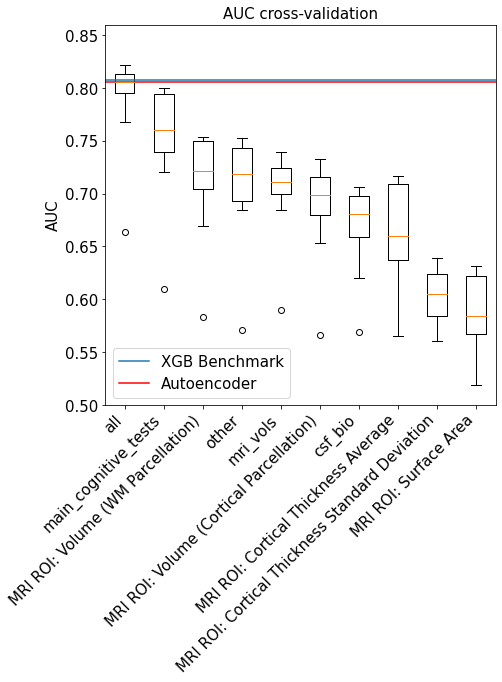

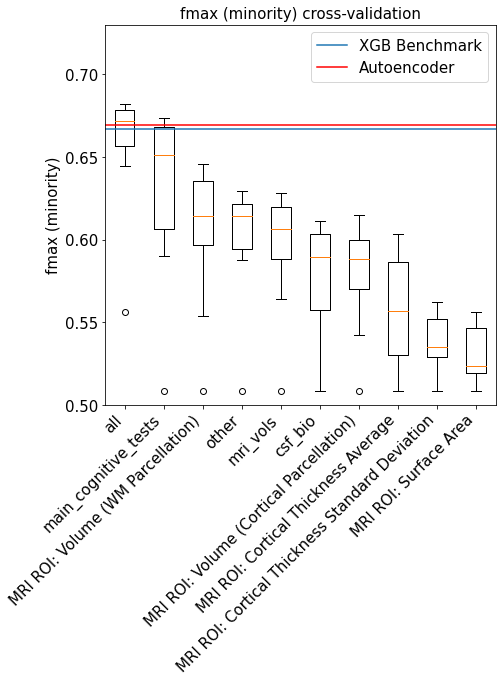

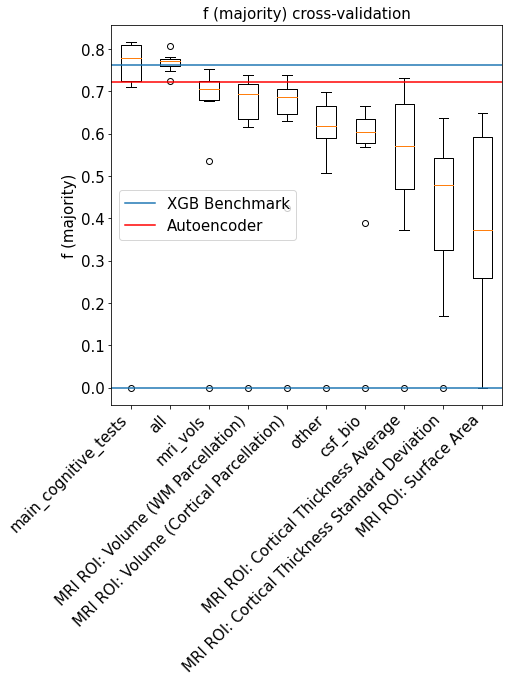

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
#est = '100'
xgb_exten = '_undersampling'
ei_exten = '_undersample_test'
model_perf = {}
xg_perf = {}
autoencoder_scores = {'AUC': 0.8057, 'fmax (minority)': 0.669, 'f (majority)': 0.722}
#for metric in ['fmax (minority)', 'AUC', 'f (majority)', 'AUPRC']:
for metric in ['AUC', 'fmax (minority)', 'f (majority)']:
    XGB = EnsembleIntegration.load(f'output/models/EI.XGB_mci_bl_train{xgb_exten}')

    if metric == 'AUPRC':
        y_pred = []
        y_true = []
        for i in range(5):
            y_pred += list(np.array(XGB.meta_test_data[i])[:,0])
            y_true += list(np.array(XGB.meta_test_data[i])[:,1])
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        auprc = auc(recall, precision)
        XGB_perf = auprc
    else:
        XGB_perf = XGB.base_summary['metrics']['unimode'].T[metric][0]
        
    xg_perf[metric] = XGB_perf

    problem = 'mci_bl'
    data_split = 'train'
    ei_dict = {}
    ei_scores = {}
    ei_models_scores = {}
    ei_dict['all'] = EnsembleIntegration.load(f'output/models/EI.mci_bl{ei_exten}')
    # AUPRC
    if metric == 'AUPRC':
        ei_models_scores['all'] = AUPRC_EI(ei_dict['all'])
        ei_scores['all'] = list(AUPRC_EI(ei_dict['all'])['AUPRC'])
    else:
        ei_models_scores['all'] = ei_dict['all'].meta_summary['metrics'].T[metric]
        ei_scores['all'] = list(ei_dict['all'].meta_summary['metrics'].T[metric])


    model_perf[metric] = ei_models_scores['all']
    for mode in tadpole_data[problem][data_split]:
        ei_dict[mode] = EnsembleIntegration.load(f'output/models/EI.{problem}_{mode}{ei_exten}')

        if metric == 'AUPRC':
            #print(AUPRC_EI(ei_dict[mode]))
            ei_scores[mode] = list(AUPRC_EI(ei_dict[mode])['AUPRC'])

        else:
            ei_scores[mode] = list(ei_dict[mode].meta_summary['metrics'].T[metric])

    data_dict = ei_scores
    medians = [(key, statistics.median(values)) for key, values in data_dict.items()]

    # Sort the list of tuples by the second element (median)
    sorted_medians = sorted(medians, key=lambda x: x[1], reverse=True)

    # Create a new dictionary using the sorted keys
    sorted_dict = {key: data_dict[key] for key, median in sorted_medians}

    fig, ax = plt.subplots(figsize=(7,7))

    ax.boxplot(sorted_dict.values())
    ax.set_xticklabels(sorted_dict.keys())
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.ylabel(metric, fontsize=15)
    if metric == 'fmax (minority)':
        plt.ylim([0.5, 0.73])
    elif metric == 'AUC':
        plt.ylim([0.5, 0.86])
    plt.yticks(fontsize=15)
    plt.axhline(XGB_perf, label='XGB Benchmark')
    plt.axhline(autoencoder_scores[metric], label='Autoencoder', color='r')
    plt.axhline()
    plt.title(f'{metric} cross-validation', fontsize=15)
    plt.legend(fontsize=15)
    #plt.tight_layout()
    plt.show()

In [66]:
#metric = 'fmax (minority)'
metric = 'AUC'
print(f'XGB: {xg_perf[metric]}')
model_perf[metric][model_perf[metric] > xg_perf[metric]].sort_values(ascending=False) 

XGB: 0.8216408568020739


S.LR                  0.828590
S.RF                  0.827319
S.GradientBoosting    0.821927
Name: AUC, dtype: float64

AUC: CES, S.GradientBoosting, S.LR, S.RF are better. S.RF is best at 0.831. XGB Benchmark is 0.822 

Fmax: Mean, CES, S.GradientBoosting, S.LR, S.NB, S.RF, S.XGB are better. S.NB best at 0.688. XGB benchmark is 0.6699

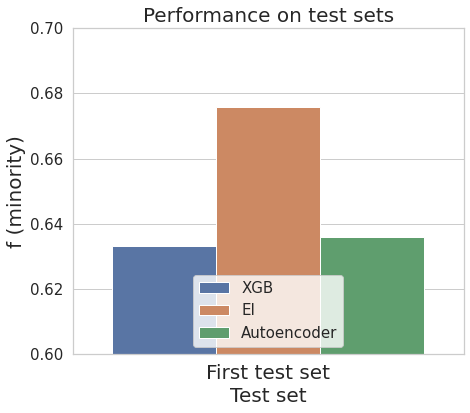

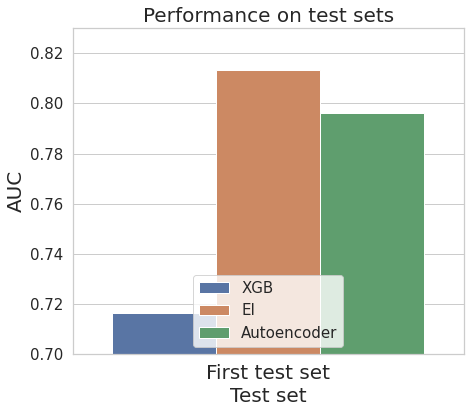

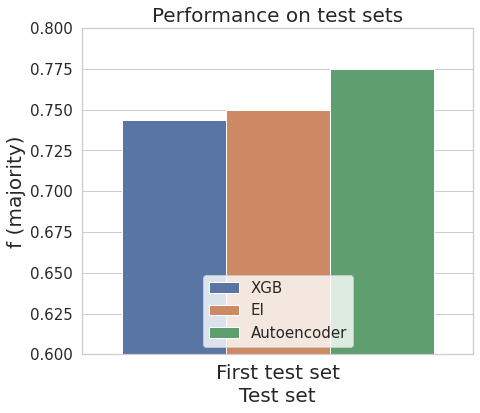

In [46]:
from sklearn.metrics import roc_auc_score
scores = {}
est = '100'
xgb_exten = '_undersampling'
ei_exten = '_undersample_test'
for metric in ['fmax (minority)', 'AUC', 'f (majority)']:
    if metric == 'fmax (minority)':
        metric_string = 'f (minority)'
    elif metric == 'AUC':
        metric_string = 'AUC'
    elif metric == 'f (majority)':
        metric_string = 'f (majority)'
    elif metric == 'AUPRC':
        metric_string = 'AUPRC'


    xgb_test = concatenated['test']
    ei_test = tadpole_data['mci_bl']['test']
    y_test = np.array(tadpole_labels['mci_bl']['test'].map({'MCI': 0.0, 'DEM': 1.0}))

    ei_ext_test = tadpole_data['cn_bl_to_mci']['full']
    xgb_ext_test = concatenated['ext_test']
    y_ext_test = np.array(tadpole_labels['cn_bl_to_mci']['full'].map({'MCI': 0.0, 'DEM': 1.0}))

    scores[metric_string] = {}
    scores[metric_string]['First test set'] = {}
    #scores[metric_string]['Second test set'] = {}

    XGB = EnsembleIntegration.load(f'output/models/EI.XGB_mci_bl_train{xgb_exten}')
    base_models_list = copy.deepcopy(XGB.final_models["base models"]["unimode"])
    XGB_dicts = [dictionary for dictionary in base_models_list if dictionary["model name"] == "XGB"]
    XGB_model = pickle.loads(XGB_dicts[0]["pickled model"])
    fmax_minor_thresh = XGB.base_summary['thresholds']['unimode']['XGB'][0]
    test_preds = XGB_model.predict(xgb_test)
    ext_test_preds = XGB_model.predict(xgb_ext_test)
    xgb_metrics = {}
    if metric == 'fmax (minority)':
        scores[metric_string]['First test set']['XGB'] = fmeasure_score(y_test, test_preds, pos_label=1, thres = fmax_minor_thresh)['F']
        #scores[metric_string]['Second test set']['XGB'] = fmeasure_score(y_ext_test, ext_test_preds, pos_label=1, thres = fmax_minor_thresh)['F']
    elif metric == 'AUC':
        scores[metric_string]['First test set']['XGB'] = roc_auc_score(y_test, test_preds)
        #scores[metric_string]['Second test set']['XGB'] = roc_auc_score(y_ext_test, ext_test_preds)
    elif metric == 'f (majority)':
        scores[metric_string]['First test set']['XGB'] = fmeasure_score(y_test, test_preds, pos_label=0, thres = 1-fmax_minor_thresh)['F']
        #scores[metric_string]['Second test set']['XGB'] = fmeasure_score(y_ext_test, ext_test_preds, pos_label=0, thres = 1-fmax_minor_thresh)['F']
    if metric == 'AUPRC':
        y_pred = test_preds
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        auprc = auc(recall, precision)
        scores[metric_string]['First test set'][f'XGB'] = auprc
        
        y_pred = ext_test_preds
        precision, recall, _ = precision_recall_curve(y_ext_test, y_pred)
        auprc = auc(recall, precision)
        #scores[metric_string]['Second test set'][f'XGB'] = auprc



    EI_model = EnsembleIntegration.load(f'output/models/EI.mci_bl{ei_exten}')
    pos = EI_model.meta_summary['metrics'].T['fmax (minority)'].argmax()
    meta_model_key = EI_model.meta_summary['metrics'].T.iloc[pos].name
    #for meta_model_key in ['S.NB', 'S.LR', 'S.RF', 'S.XGB', 'S.GradientBoosting', 'S.AdaBoost']:
    test_preds = EI_model.predict(ei_test, meta_model_key=meta_model_key)
    ext_test_preds = EI_model.predict(ei_ext_test, meta_model_key=meta_model_key)
    fmax_minor_thresh = list(EI_model.meta_summary['thresholds'][meta_model_key])[0]
    ei_metrics = {}
    if metric == 'fmax (minority)':
        scores[metric_string]['First test set'][f'EI'] = fmeasure_score(y_test, test_preds, pos_label=1, thres = fmax_minor_thresh)['F']
        #scores[metric_string]['Second test set'][f'EI'] = fmeasure_score(y_ext_test, ext_test_preds, pos_label=1, thres = fmax_minor_thresh)['F']
    elif metric == 'AUC':
        scores[metric_string]['First test set'][f'EI'] = roc_auc_score(y_test, test_preds)
        #scores[metric_string]['Second test set'][f'EI'] = roc_auc_score(y_ext_test, ext_test_preds)
    elif metric == 'f (majority)':
        scores[metric_string]['First test set'][f'EI'] = fmeasure_score(y_test, test_preds, pos_label=0, thres = 1-fmax_minor_thresh)['F']
        #scores[metric_string]['Second test set'][f'EI'] = fmeasure_score(y_ext_test, ext_test_preds, pos_label=0, thres = 1-fmax_minor_thresh)['F']
    if metric == 'AUPRC':
        y_pred = test_preds
        precision, recall, _ = precision_recall_curve(y_test,test_preds)
        auprc = auc(recall, precision)
        scores[metric_string]['First test set'][f'EI'] = auprc
        
        y_pred = ext_test_preds
        precision, recall, _ = precision_recall_curve(y_ext_test, ext_test_preds)
        auprc = auc(recall, precision)
        #scores[metric_string]['Second test set'][f'EI'] = auprc

plt.rcParams.update({'font.size': 20})

scores['AUC']['First test set']['Autoencoder'] = 0.796
scores['f (minority)']['First test set']['Autoencoder'] = 0.636
scores['f (majority)']['First test set']['Autoencoder'] = 0.775


import seaborn as sns
import matplotlib.pyplot as plt
for metric in scores:
        
    flat_data = [(category, subcategory, value) for category, subdict in scores[metric].items() for subcategory, value in subdict.items()]

    # Create a DataFrame from the flat list
    df = pd.DataFrame(flat_data, columns=['Category', 'Model', 'Value'])

    # Create a Seaborn bar plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(7, 6))
    sns.barplot(x='Category', y='Value', hue='Model', data=df)
    plt.title(f'Performance on test sets', fontsize=20)    
    plt.xlabel('Test set', fontsize=20)
    plt.ylabel(metric, fontsize=20)
    plt.xticks(rotation=0, fontsize=20)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15, loc='lower center')
    if metric == 'f (minority)':
        plt.ylim([0.60, 0.7])
    if metric == 'AUC':
        plt.ylim([0.70, 0.83])
    if metric == 'f (majority)':
        plt.ylim([0.6, 0.8])
    #plt.ylim([0.5, 0.81])
    plt.show()

In [16]:
EI_model.meta_summary['metrics']

,Mean,CES,S.AdaBoost,S.DT,S.GradientBoosting,S.KNN,S.LR,S.NB,S.MLP,S.RF,S.SVM,S.XGB
fmax (minority),0.678322,0.670391,0.644660,0.631164,0.678766,0.671164,0.673347,0.681004,0.663366,0.682143,0.596737,0.658228
f (majority),0.761658,0.780669,0.779252,0.776583,0.776797,0.740346,0.807101,0.773537,0.723577,0.772959,0.810929,0.761062
AUC,0.803030,0.805958,0.768155,0.702145,0.813632,0.817151,0.815618,0.809842,0.803730,0.821695,0.698212,0.804588
max MCC,0.484330,0.461287,0.409301,0.416063,0.482278,0.472328,0.486284,0.479043,0.454519,0.491119,0.410954,0.451180


### Interpretation

In [67]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier

project_name = 'mci_bl_xgb_100_est_undersampling'
EI_object = EnsembleIntegration().load(f'output/models/EI.{project_name}')

base_predictors = EI_object.base_predictors
meta_models = EI_object.meta_models

if 'CES' in meta_models:    
    del meta_models['CES']

In [68]:
EI_object.sampling_strategy

'undersampling'

In [15]:
data_file_path = 'data/processed/tadpole_data_train_test.pickle'
with open(data_file_path, 'rb') as file:
    named_data = pickle.load(file)

interp_data = {}
for mode in named_data['mci_bl']['train']:
    if mode == 'other':
        interp_data[mode] = pd.DataFrame(tadpole_data['mci_bl']['train'][mode], columns = ['DX_bl','AGE','PTGENDER','PTEDUCAT','PTETHCAT','PTRACCAT','PTMARRY','FDG','APOE_0','APOE_1','APOE_2'])
    else:
        interp_data[mode] = pd.DataFrame(tadpole_data['mci_bl']['train'][mode], columns = named_data['mci_bl']['train'][mode].columns)

In [17]:
problem = 'mci_bl'
data_split = 'train'
x = interp_data
y = np.array(tadpole_labels[problem][data_split].map({'MCI': 0.0, 'DEM': 1.0})).astype(int)

EI_int = EI_interpreter(EI_object=EI_object,
                        base_predictors=base_predictors,
                        meta_models=meta_models,
                        modalities=x,
                        y=y,
                        metric=f_minority_score)

EI_int.rank_product_score()
best_EI_model = EnsembleIntegration().load(f"output/models/EI.{project_name}").meta_summary['metrics'].T.sort_values(by='fmax (minority)', ascending=False)['fmax (minority)'].keys()[0]
final_int = EI_int.ensemble_feature_ranking[f"{best_EI_model}"]
final_int.to_csv(f'INT_{project_name}.csv')


 Working on main_cognitive_tests data... 

Training base predictors on outer training sets...

 Working on mri_vols data... 

Training base predictors on outer training sets...

 Working on csf_bio data... 

Training base predictors on outer training sets...

 Working on other data... 

Training base predictors on outer training sets...

 Working on MRI ROI: Volume (WM Parcellation) data... 

Training base predictors on outer training sets...

 Working on MRI ROI: Volume (Cortical Parcellation) data... 

Training base predictors on outer training sets...

 Working on MRI ROI: Surface Area data... 

Training base predictors on outer training sets...

 Working on MRI ROI: Cortical Thickness Average data... 

Training base predictors on outer training sets...

 Working on MRI ROI: Cortical Thickness Standard Deviation data... 

Training base predictors on outer training sets...
      local_model_PI base predictor  \
0                0.0             NB   
1                0.0             

KeyError: 'S.RF'

In [28]:
data_file_path = 'data/processed/tadpole_data_train_test.pickle'
with open(data_file_path, 'rb') as file:
    data = pickle.load(file)

In [18]:
final_int = EI_int.ensemble_feature_ranking[f"S.S.RF"]
final_int.to_csv(f'INT_{project_name}.csv')

In [24]:
#fdr_df = pd.read_csv('output/tables/fdr_differential_analysis.csv')
for keys in EI_int.ensemble_feature_ranking.keys():
    final_int = EI_int.ensemble_feature_ranking[keys]
    final_int.to_csv(f'output/interpretation/INT_{keys}_{project_name}.csv')

In [26]:
EI_int.ensemble_feature_ranking['S.S.RF']['feature']

264        Cortical Thickness Average of RightEntorhinal
296    Cortical Thickness Standard Deviation of LeftC...
78                 Volume (Cortical Parcellation) of Icv
104    Volume (Cortical Parcellation) of LeftMedialOr...
66          Volume (WM Parcellation) of RightHippocampus
                             ...                        
289    Cortical Thickness Standard Deviation of Right...
23                                              PTETHCAT
6                                       RAVLT_forgetting
11                                            WholeBrain
18                             PTAU_UPENNBIOMK9_04_19_17
Name: feature, Length: 343, dtype: object

In [56]:
list(ei_dict['all'].meta_summary['metrics'].T['fmax (minority)'])

[0.6727941176470589,
 0.6837294332723949,
 0.6469622331691297,
 0.6442477876106194,
 0.6804511278195489,
 0.6690391459074734,
 0.6879699248120301,
 0.6885245901639344,
 0.6666666666666666,
 0.6735042735042734,
 0.6457023060796645,
 0.6830985915492958]

In [7]:
XGB = EnsembleIntegration.load('EI.XGB_mci_bl_train')
base_models_list = copy.deepcopy(XGB.final_models["base models"]["unimode"])
XGB_dicts = [dictionary for dictionary in base_models_list if dictionary["model name"] == "XGB"]
XGB_model = pickle.loads(XGB_dicts[0]["pickled model"])
fmax_minor_thresh = XGB.base_summary['thresholds']['unimode']['XGB'][0]

In [5]:
preds = XGB_model.predict(concatenated['test'])

In [9]:
y = np.array(tadpole_labels[problem]['test'].map({'MCI': 0.0, 'DEM': 1.0}))
score = fmeasure_score(y, preds, pos_label=1, thres = fmax_minor_thresh)
score

{'P': 0.5857142857142857, 'R': 0.7192982456140351, 'F': 0.6456692913385826}

In [53]:
XGB.final_models["base models"]

{'unimode': [{'model name': 'XGB',
   'sample id': 0,
   'pickled model': b'\x80\x04\x95\xba\x03\x00\x00\x00\x00\x00\x00\x8c\x0fxgboost.sklearn\x94\x8c\rXGBClassifier\x94\x93\x94)\x81\x94}\x94(\x8c\x11use_label_encoder\x94\x89\x8c\x0cn_estimators\x94Kd\x8c\tobjective\x94\x8c\x0fbinary:logistic\x94\x8c\tmax_depth\x94N\x8c\nmax_leaves\x94N\x8c\x07max_bin\x94N\x8c\x0bgrow_policy\x94N\x8c\rlearning_rate\x94N\x8c\tverbosity\x94N\x8c\x07booster\x94N\x8c\x0btree_method\x94N\x8c\x05gamma\x94N\x8c\x10min_child_weight\x94N\x8c\x0emax_delta_step\x94N\x8c\tsubsample\x94N\x8c\x0fsampling_method\x94N\x8c\x10colsample_bytree\x94N\x8c\x11colsample_bylevel\x94N\x8c\x10colsample_bynode\x94N\x8c\treg_alpha\x94N\x8c\nreg_lambda\x94N\x8c\x10scale_pos_weight\x94N\x8c\nbase_score\x94N\x8c\x07missing\x94G\x7f\xf8\x00\x00\x00\x00\x00\x00\x8c\x11num_parallel_tree\x94N\x8c\x0crandom_state\x94K*\x8c\x06n_jobs\x94N\x8c\x14monotone_constraints\x94N\x8c\x17interaction_constraints\x94N\x8c\x0fimportance_type\x94N\x8c

In [43]:
XGB.base_summary['metrics']

modality,unimode
base predictor,XGB
fmax (minority),0.634375
f (majority),0.667614
AUC,0.733506
max MCC,0.394597


In [7]:
tadpole_data['mci_bl']['train']['other']

,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG
476,EMCI,71.7,Female,12,NotHispLatino,White,Married,1.0,1.24136
836,LMCI,76.1,Male,20,NotHispLatino,White,Married,1.0,1.26727
796,EMCI,61.8,Male,20,NotHispLatino,White,Married,0.0,1.31228
494,EMCI,70.6,Male,16,NotHispLatino,White,Married,0.0,1.25107
94,LMCI,71.5,Female,16,NotHispLatino,White,Married,1.0,1.21855
...,...,...,...,...,...,...,...,...,...
110,LMCI,74.7,Male,16,NotHispLatino,White,Married,1.0,NaN
290,LMCI,80.2,Male,16,NotHispLatino,Black,Married,0.0,NaN
454,EMCI,78.6,Female,18,NotHispLatino,White,Married,0.0,1.32105
15,LMCI,85.0,Male,18,NotHispLatino,White,Married,1.0,1.21013


In [8]:
process_tadpole_dict['mci_bl']['train']['other']

array([[0.        , 0.46296296, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.62222222, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.13333333, 1.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.7037037 , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.91481481, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.25925926, 1.        , ..., 1.        , 0.        ,
        0.        ]])

In [6]:
tadpole_data.keys()

dict_keys(['mci_bl', 'cn_bl', 'cn_bl_to_mci'])

In [18]:
new_mode_name_dict = {'main_cognitive_tests': 'Main cognitive tests', 'mri_vols': 'MRI volumes', 'csf_bio': 'CSF biomarkers',
       'other': 'Other','MRI ROI: Volume (WM Parcellation)': 'MRI ROI: Volume (WM Parcellation)',
       'MRI ROI: Volume (Cortical Parcellation)':'MRI ROI: Volume (Cortical Parcellation)', 
       'MRI ROI: Surface Area':'MRI ROI: Surface Area',
       'MRI ROI: Cortical Thickness Average':'MRI ROI: Cortical Thickness Average',
       'MRI ROI: Cortical Thickness Standard Deviation':'MRI ROI: Cortical Thickness Standard Deviation'}
all_feats_df = pd.DataFrame()
for mode in tadpole_data['mci_bl']['full']:
    for feat in tadpole_data['mci_bl']['full'][mode]:
        new_row = pd.DataFrame({'Feature': [feat], 'Modality': [new_mode_name_dict[mode]]})
        all_feats_df = pd.concat([all_feats_df, new_row], axis=0)
all_feats_df.reset_index(inplace=True, drop=True)

In [21]:
all_feats_df

,Feature,Modality
0,CDRSB,Main cognitive tests
1,ADAS11,Main cognitive tests
2,ADAS13,Main cognitive tests
3,MMSE,Main cognitive tests
4,RAVLT_immediate,Main cognitive tests
...,...,...
336,Cortical Thickness Standard Deviation of Right...,MRI ROI: Cortical Thickness Standard Deviation
337,Cortical Thickness Standard Deviation of Right...,MRI ROI: Cortical Thickness Standard Deviation
338,Cortical Thickness Standard Deviation of Right...,MRI ROI: Cortical Thickness Standard Deviation
339,Cortical Thickness Standard Deviation of Right...,MRI ROI: Cortical Thickness Standard Deviation


In [20]:
all_feats_df.to_csv('output/tables/all_features.csv')

In [3]:
tadpole_labels

{'cn_bl': {'full': 0             NL
  1             NL
  2      NL to MCI
  3             NL
  4      NL to MCI
           ...    
  401           NL
  402           NL
  403           NL
  404           NL
  405           NL
  Name: last_dx, Length: 406, dtype: object,
  'train': 20     CN
  147    CN
  290    CN
  224    CN
  110    CN
         ..
  373    CN
  138    CN
  376    CN
  240    CN
  137    CN
  Name: last_dx, Length: 324, dtype: object,
  'test': 336    CN
  317    CN
  212    CN
  181    CN
  96     CN
         ..
  237    CN
  357    CN
  267    CN
  289    CN
  269    CN
  Name: last_dx, Length: 82, dtype: object},
 'mci_bl': {'full': 0                  MCI
  1                  MCI
  2                  MCI
  3                  MCI
  4             Dementia
              ...       
  836    MCI to Dementia
  837                MCI
  838                MCI
  839                MCI
  840                 NL
  Name: last_dx, Length: 841, dtype: object,
  'train': 476    MC

In [3]:
table1_dict = {}
dx_set = 'cn_bl_to_mci'
other_dict = {}
for div in tadpole_data[dx_set]:
    
    other_dict[div] = pd.concat([tadpole_labels[dx_set][div], tadpole_data[dx_set][div]['other']], axis=1)
    other_dict[div]['last_dx'] = other_dict[div]['last_dx'].map({'MCI': 'MCI', 'Dementia': 'Dementia',
                                                                    'MCI to Dementia': 'Dementia',
                                                                    'MCI to NL': 'MCI',
                                                                    'NL': 'MCI',
                                                                    'NL to MCI': 'MCI',
                                                                    'Dementia to MCI': 'MCI',
                                                                    'DEM': 'Dementia'})
other_dict_by_dx = {}
for div in other_dict:
    other_dict_by_dx[div] = {}
    other_dict_by_dx[div]['MCI'] = other_dict[div][other_dict[div]['last_dx'] == 'MCI']
    other_dict_by_dx[div]['Dementia'] = other_dict[div][other_dict[div]['last_dx'] == 'Dementia']
    other_dict_by_dx[div]['All'] = other_dict[div]

cont_vars = ['AGE', 'PTEDUCAT', 'FDG']
cat_vars = ['DX_bl', 'PTGENDER', 'PTETHCAT', 'PTRACCAT','PTMARRY', 'APOE4']

In [4]:
var_name_map = {'AGE': 'Age at baseline', 'PTEDUCAT': 'Years of education', 'FDG': 'Average FDG-PET of angular, temporal, and posterior cingulate',
                'DX_bl': 'Diagnosis at baseline', 'PTGENDER': "Sex", 'PTETHCAT': 'Ethnicity', 'PTRACCAT': 'Race',
                'PTMARRY': 'Marital Status', 'APOE4': 'APOE4 Allele'}

# Do for full first, then train and test
for div in tadpole_data[dx_set]:
    table1_dict[div] = pd.DataFrame()
    temp_dict = {}

    data = other_dict_by_dx[div]
    temp_dict['All patients'] = pd.DataFrame({'All patients': [data['All'].shape[0], data['MCI'].shape[0], 
                                                               data['Dementia'].shape[0]]}).T
    temp_dict['All patients'].rename(columns = {0: 'Overall', 1: 'Stayed at MCI', 2: 'Progressed to dementia'}, inplace=True)

    for cov in cont_vars:
        cols = {}
        for dx in ['All', 'MCI', 'Dementia']:
            data = other_dict_by_dx[div][dx][cov].dropna()
            median = round(data.median(), 2)
            q1 = round(np.percentile(data, 25), 2)
            q3 = round(np.percentile(data, 75), 2)
            full_str = f'{median} ({q1}, {q3})'
            cols[dx] = full_str

        temp_dict[cov] = pd.DataFrame({var_name_map[cov]: [cols['All'], cols['MCI'], cols['Dementia']]}).T
        temp_dict[cov].rename(columns = {0: 'Overall', 1: 'Stayed at MCI', 2: 'Progressed to dementia'}, inplace=True)

    for cav in cat_vars:    
        cols = {}
        for cav_unq in other_dict_by_dx[div]['All'][cav].unique():
            for dx in ['All', 'MCI', 'Dementia']:
                data = other_dict_by_dx[div][dx][cav]
                data_unq = data[data == cav_unq]
                n = data_unq.shape[0]
                perc = round(100 * n/data.shape[0], 1)
                
                full_str = f'{n} ({perc}%)'
                cols[dx] = full_str

            temp_dict[cav_unq] = pd.DataFrame({cav_unq: [cols['All'], cols['MCI'], cols['Dementia']]}).T
            temp_dict[cav_unq].rename(columns = {0: 'Overall', 1: 'Stayed at MCI', 2: 'Progressed to dementia'}, inplace=True)

    for mode in temp_dict:
        table1_dict[div] = pd.concat([table1_dict[div], temp_dict[mode]], axis=0)

    row_to_move = table1_dict[div].iloc[3]
    table1_dict[div].drop(table1_dict[div].index[3], inplace=True)
    table1_dict[div] = table1_dict[div].append(row_to_move)
    table1_dict[div].rename_axis('Variables')

/tmp/ipykernel_4016582/3297202174.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table1_dict[div] = table1_dict[div].append(row_to_move)


In [7]:
for div in table1_dict:
    table1_dict[div].to_csv(f'output/table1_for_test_2_data.csv')

In [6]:
table1_dict['full']

,Overall,Stayed at MCI,Progressed to dementia
All patients,84,68,16
Age at baseline,"75.7 (72.4, 79.58)","75.7 (72.35, 80.03)","74.7 (72.47, 77.93)"
Years of education,"16.0 (14.0, 18.0)","16.0 (14.75, 18.0)","16.0 (13.75, 18.0)"
CN,84 (100.0%),68 (100.0%),16 (100.0%)
Male,47 (56.0%),41 (60.3%),6 (37.5%)
Female,37 (44.0%),27 (39.7%),10 (62.5%)
NotHispLatino,83 (98.8%),67 (98.5%),16 (100.0%)
HispLatino,1 (1.2%),1 (1.5%),0 (0.0%)
White,74 (88.1%),59 (86.8%),15 (93.8%)
Black,9 (10.7%),8 (11.8%),1 (6.2%)


In [190]:
#table1_master = pd.merge(table1_dict['full'], table1_dict['train'], left_index=True, right_index=True, suffixes=(' (whole cohort)', ' (training set)'))
#table1_master = pd.merge(table1_master, table1_dict['test'], left_index=True, right_index=True).rename(columns = {'Overall': 'Overall (test set)',
                                                                                                                  #'Stayed at MCI': 'Stayed at MCI (test set)',
                                                                                                                  #'Progressed to dementia': 'Progressed to dementia (test set)'})
table1_master.to_csv('output/table1_cn_bl_to_mci.csv')

In [ ]:
table1_master = pd.merge()

In [79]:
pd.DataFrame({'row1': ['column 1', 'column 2']}).T

,0,1
row1,column 1,column 2


In [35]:
other_dict['train']

,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG
476,EMCI,71.7,Female,12,NotHispLatino,White,Married,1.0,1.24136
836,LMCI,76.1,Male,20,NotHispLatino,White,Married,1.0,1.26727
796,EMCI,61.8,Male,20,NotHispLatino,White,Married,0.0,1.31228
494,EMCI,70.6,Male,16,NotHispLatino,White,Married,0.0,1.25107
94,LMCI,71.5,Female,16,NotHispLatino,White,Married,1.0,1.21855
...,...,...,...,...,...,...,...,...,...
110,LMCI,74.7,Male,16,NotHispLatino,White,Married,1.0,NaN
290,LMCI,80.2,Male,16,NotHispLatino,Black,Married,0.0,NaN
454,EMCI,78.6,Female,18,NotHispLatino,White,Married,0.0,1.32105
15,LMCI,85.0,Male,18,NotHispLatino,White,Married,1.0,1.21013


# Continuous -> median + IQR
# Categorical -> n and % of pop within column

In [36]:
other_dict['full']

,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG
0,LMCI,67.5,Male,10,HispLatino,White,Married,0.0,NaN
1,LMCI,80.4,Female,13,NotHispLatino,White,Married,0.0,NaN
2,LMCI,83.3,Male,20,NotHispLatino,White,Married,0.0,1.10567
3,LMCI,76.8,Male,12,NotHispLatino,White,Married,0.0,NaN
4,LMCI,70.9,Female,14,NotHispLatino,White,Married,2.0,NaN
...,...,...,...,...,...,...,...,...,...
836,LMCI,76.1,Male,20,NotHispLatino,White,Married,1.0,1.26727
837,EMCI,61.7,Male,16,NotHispLatino,White,Married,0.0,1.44797
838,EMCI,85.3,Male,20,NotHispLatino,White,Married,1.0,1.15241
839,EMCI,79.7,Male,17,NotHispLatino,White,Widowed,1.0,1.16025


In [ ]:
other_dict_by_dx = {}
for 